In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eqmarl import *
import gymnasium as gym
from functools import reduce
import tensorflow_quantum as tfq
import tensorflow as tf
import tensorflow.keras as keras
import cirq
import tqdm

2023-11-07 17:18:16.695071: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# env_name = "FrozenLake-v1"
env_name = "CartPole-v1"
# env_name = "MountainCar-v0"
env = gym.make(env_name)
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

In [4]:
# Actor Critic in TensorFlow.
# https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic

In [5]:
tf.compat.v1.enable_eager_execution()

In [6]:
def run_episode(
    env: gym.Env,
    max_steps: int,
    actor: keras.Model,
    critic: keras.Model,
    action_selection_fn: Callable[[tf.Tensor], int],
    ):
    
    # history: list[dict] = [] # dict(state, action, reward, next_state)
    actions = [] # tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    action_probs = [] # tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = [] # tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = [] # tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

    state, _ = env.reset()
    state_shape = state.shape # Preserve state shape, required to correct returned next state shape for usage with `tf.numpy_function`.
    # for t in tf.range(max_steps):
    for t in tf.range(max_steps):
        # print(f"{t=}")
        
        # Convert state to batched tensor (batch size = 1).
        state = tf.expand_dims(state, 0)

        # Get action probabilities at current state.
        probs = actor(state)

        # Select action.
        action = tf.convert_to_tensor(action_selection_fn(probs), dtype=tf.int64)
        action_prob = probs[0, action] # Get probability distribution at current action selection.

        # Get value from critic at current state.
        value = critic(state)

        # Interact with environment using selected action.
        def env_step(
            action: np.ndarray,
            ) -> tuple[np.ndarray, np.ndarray, np.int32]:
            """Wrapper for converting action to numpy array for environment step.
            
            Note that the environment object must be used implicitly via scoping, because it cannot be passed as an argument to `tf.numpy_function` (which requires Tensors).
            """
            state, reward, done, _, _ = env.step(action)
            # print(f"inside: {done=}")
            return (
                np.array(state, dtype=np.float32), 
                np.array(reward, dtype=np.float32), 
                np.array(done, dtype=np.int32),
                # done,
                )
        state, reward, done = tf.numpy_function(env_step, [action], Tout=[tf.float32, tf.float32, tf.int32])
        state.set_shape(state_shape)
        reward.set_shape(())
        # done.set_shape(())
        # done = tf.get_static_value(done)
        # print(f"{state=}")
        # print(f"{done=}")
        # print(f"{tf.equal(done, 1)=}")
        # print(f"{tf.cast(done, tf.bool)=}")
        # state, reward, done, _, _ = env.step(action)
        # tf.print('done:', done, "action:", action, "state:", state)

        # # Preserve action probabilities, values, and rewards.
        # actions.write(t, tf.squeeze(action))
        # action_probs.write(t, tf.squeeze(action_prob))
        # values.write(t, tf.squeeze(value))
        # rewards.write(t, tf.squeeze(reward))
        
        actions.append(action)
        action_probs.append(action_prob)
        values.append(value)
        rewards.append(reward)

        # Terminate episode if environment terminates.
        if tf.cast(done, tf.bool):
        # if tf.greater(done, 0):
            break
        
    # actions.mark_used()
    # action_probs.mark_used()
    # values.mark_used()
    # rewards.mark_used()
    
    # # Build tensors from dynamic elements using `stack()`.
    # actions = actions.stack()
    # action_probs = action_probs.stack()
    # values = values.stack()
    # rewards = rewards.stack()
    
    return actions, action_probs, values, rewards

In [7]:
def get_expected_returns(
    rewards: tf.Tensor,
    gamma: float,
    standardize: bool = True,
    eps: float = 1e-8,
    ) -> tf.Tensor:
    """Computes expected returns per timestep.
    
    Inspired by: https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic#2_compute_the_expected_returns
    """
    # Start from the end and accumulate reward backwards.
    rewards = rewards[::-1]
    n_returns = tf.shape(rewards)[0]
    returns = tf.TensorArray(dtype=tf.float32, size=n_returns)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in tf.range(n_returns):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum) # Preserve the return value at the current time index.
    returns = returns.stack()[::-1] # Use `stack()` to build Tensor and `[::-1]` to reverse to original time-sorted order.
    
    # Standardize to zero mean and unit standard deviation.
    if standardize:
        returns = (returns - tf.math.reduce_mean(returns))/(tf.math.reduce_std(returns) + eps)
    
    return returns

In [8]:
# @tf.function
def compute_actor_loss(
    action_probs: tf.Tensor,
    values: tf.Tensor, # Values from critic.
    returns: tf.Tensor,
    ) -> tf.Tensor:

    # Compute advantage, which is difference between actor's expected return and critic's value.
    advantage = returns - values

    # Compute natural log of action probabilities.
    action_probs_log = tf.math.log(action_probs)

    # Compute actor loss, which is the negative of the sum of log-probabilities multiplied by the advantage.
    actor_loss = -tf.math.reduce_sum(action_probs_log * advantage)
    return actor_loss

In [9]:
# @tf.function
def train_step(
    env: gym.Env,
    actor: keras.Model,
    critic: keras.Model,
    optimizer_actor: Union[keras.optimizers.Optimizer, list[keras.optimizers.Optimizer]], # If list, then the optimizer at index `i` will be associated with `actor_grads[i]`.
    optimizer_critic: Union[keras.optimizers.Optimizer, list[keras.optimizers.Optimizer]],
    gamma: float,
    max_steps_per_episode: int,
    action_selection_fn: Callable[[tf.Tensor], int] = lambda probs: tf.argmax(probs, axis=1)[0], # Greedy, always take action with highest probability.
    ) -> tf.Tensor:
    
    compute_critic_loss = keras.losses.Huber(reduction=keras.losses.Reduction.SUM)
    
    # action_selection_fn = lambda probs: tf.argmax(probs, axis=1)[0] # Greedy, always take action with highest probability.
    
    with tf.GradientTape() as tape_actor, tf.GradientTape() as tape_critic:
        
        # Collect training data by running the model for one episode in the environment.
        actions, action_probs, values, rewards = run_episode(
            env, max_steps_per_episode, actor, critic, action_selection_fn
        )
        
        # state, _ = env.reset()
        # state = tf.expand_dims(state, 0)
        # probs = actor(state)
        # value = critic(state)
        
        # Compute expected returns.
        returns = get_expected_returns(rewards, gamma)
        
        # Compute actor loss.
        actor_loss = compute_actor_loss(action_probs, values, returns)
        
        # Compute critic loss.
        critic_loss = compute_critic_loss(values, returns)
        
    # Compute gradients of both losses.
    actor_grads = tape_actor.gradient(actor_loss, actor.trainable_variables)
    critic_grads = tape_critic.gradient(critic_loss, critic.trainable_variables)
    
    # print(f"{actor_loss=}")
    # print(f"{critic_loss=}")
    # print(f"{actor_grads=}")
    # print(f"{critic_grads=}")
    
    # Apply gradients to each model's parameters.
    if isinstance(optimizer_actor, (list, tuple)):
        for i in range(len(optimizer_actor)):
            optimizer_actor[i].apply_gradients([(actor_grads[i], actor.trainable_variables[i])])
    else:
        optimizer_actor.apply_gradients(zip(actor_grads, actor.trainable_variables))
        
    if isinstance(optimizer_critic, (list, tuple)):
        for i in range(len(optimizer_critic)):
            optimizer_critic[i].apply_gradients([(critic_grads[i], critic.trainable_variables[i])])
    else:
        optimizer_critic.apply_gradients(zip(critic_grads, critic.trainable_variables))
        
    # Compute reward for entire episode.
    episode_reward = tf.math.reduce_sum(rewards)
    return episode_reward

In [10]:
env_name = "CartPole-v1"
env = gym.make(env_name)
env.observation_space, env.action_space

n_qubits = 4 # Dimension of observation space in environment.
n_actions = 2 # Number of actions in environment.

n_layers = 5
beta = 1.0 # Inverse temperature parameter for softmax policy.

qubits = cirq.LineQubit.range(n_qubits)
ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x*y), ops)]

actor = QuantumActorVariationalEncoding(
    qubits=qubits,
    n_actions=n_actions,
    n_layers=n_layers,
    beta=beta,
    name='actor',
)
actor.summary()

critic = ClassicalCriticDense(units=[128], name='critic')
critic.build((None, *env.observation_space.shape))
critic.summary()

# model.build(input_shape=(None, n_qubits,))

# input_tensor = tf.keras.Input(shape=(n_qubits,), dtype='float32', name='input')
# x = input_tensor
# x = VariationalEncodingPQC(observables, qubits, n_layers, name='pqc')([x])
# # observables
# x = WeightedAlternatingSoftmaxPolicy(beta=beta, n_actions=n_actions, name='policy')(x)
# model = tf.keras.Model(inputs=[input_tensor], outputs=x)
# # pqc([input_tensor])
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)
# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

Model: "actor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 pqc (VariationalEncodingPQC  (None, 1)                92        
 )                                                               
                                                                 
 policy (WeightedAlternating  (None, 2)                2         
 SoftmaxPolicy)                                                  
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)         

In [11]:
actor.trainable_variables

[<tf.Variable 'theta:0' shape=(1, 72) dtype=float32, numpy=
 array([[2.7440493e+00, 5.5890793e-01, 2.7291265e+00, 2.3680325e+00,
         1.6110769e-01, 3.0183201e+00, 2.5795072e-01, 2.1940393e+00,
         3.6673638e-01, 2.4061923e+00, 3.2886323e-01, 2.2581236e+00,
         7.6796377e-01, 2.1057613e+00, 5.1637816e-01, 3.0766981e+00,
         1.7457106e+00, 1.0801394e+00, 5.5380714e-01, 1.4178275e-01,
         3.4594715e-01, 8.9173985e-01, 6.0687178e-01, 2.5345817e+00,
         2.9419756e+00, 2.9151554e+00, 2.7851233e+00, 1.3778054e+00,
         1.4185345e+00, 2.2604628e+00, 5.2487648e-01, 2.8843505e+00,
         7.2942960e-01, 2.5740232e+00, 2.5353017e+00, 3.4762830e-01,
         3.0639799e+00, 1.3269825e+00, 1.5684355e-03, 3.1086972e+00,
         4.4309500e-01, 1.3346162e+00, 5.7748085e-01, 1.3346533e+00,
         1.5029911e+00, 2.3752294e+00, 1.4240203e+00, 3.0296807e+00,
         2.0863709e+00, 3.0750196e+00, 3.0308001e+00, 3.0243058e+00,
         1.3002622e+00, 2.7566352e+00, 1.22

In [12]:
actor.trainable_weights

[<tf.Variable 'theta:0' shape=(1, 72) dtype=float32, numpy=
 array([[2.7440493e+00, 5.5890793e-01, 2.7291265e+00, 2.3680325e+00,
         1.6110769e-01, 3.0183201e+00, 2.5795072e-01, 2.1940393e+00,
         3.6673638e-01, 2.4061923e+00, 3.2886323e-01, 2.2581236e+00,
         7.6796377e-01, 2.1057613e+00, 5.1637816e-01, 3.0766981e+00,
         1.7457106e+00, 1.0801394e+00, 5.5380714e-01, 1.4178275e-01,
         3.4594715e-01, 8.9173985e-01, 6.0687178e-01, 2.5345817e+00,
         2.9419756e+00, 2.9151554e+00, 2.7851233e+00, 1.3778054e+00,
         1.4185345e+00, 2.2604628e+00, 5.2487648e-01, 2.8843505e+00,
         7.2942960e-01, 2.5740232e+00, 2.5353017e+00, 3.4762830e-01,
         3.0639799e+00, 1.3269825e+00, 1.5684355e-03, 3.1086972e+00,
         4.4309500e-01, 1.3346162e+00, 5.7748085e-01, 1.3346533e+00,
         1.5029911e+00, 2.3752294e+00, 1.4240203e+00, 3.0296807e+00,
         2.0863709e+00, 3.0750196e+00, 3.0308001e+00, 3.0243058e+00,
         1.3002622e+00, 2.7566352e+00, 1.22

In [13]:
# def asf(probs):
#     # print(f"{probs=}")
#     # print(f"{np.asarray(probs)=}")
#     # print(f"{tf.argmax(probs, axis=1)=}")
#     # print(f"{tf.argmax(probs, axis=1).eval()=}")
#     # print(f"{tf.argmax(probs, axis=1)[0]=}")
#     # print(f"{int(tf.argmax(probs, axis=1)[0])=}")
#     # return int(tf.argmax(probs, axis=1).numpy()[0])
#     # return tf.get_static_value(tf.argmax(probs, axis=1)[0])
#     return tf.argmax(probs, axis=1)[0]


# def asf(probs):
    
#     coin = np.random.random()
#     if coin > 0.3:
#         return tf.argmax(probs, axis=1)[0]
#     else:
#         return np.random.choice(n_actions)


def epsilon_greedy(probs, epsilon):
    coin = np.random.random()
    if coin > epsilon:
        return tf.argmax(probs, axis=1)[0]
    else:
        return np.random.choice(n_actions)



env = gym.make(env_name)

optimizer_actor = [
    keras.optimizers.Adam(learning_rate=0.01, amsgrad=True), # w_var (for `theta` variables)
    keras.optimizers.Adam(learning_rate=0.1, amsgrad=True), # w_in (for `lambda` variables)
    keras.optimizers.Adam(learning_rate=0.1, amsgrad=True), # w_out (for `observables-weights` variables)
]
optimizer_critic = keras.optimizers.Adam(learning_rate=0.01)


max_episodes = 10000
max_steps_per_episode = 500
epsilon = 1
min_epsilon = 0.01
decay_epsilon = 0.99

episode_rewards = []

try:
    t = tqdm.trange(max_episodes)
    for i in t:
        
        episode_reward = train_step(
            env,
            actor,
            critic,
            optimizer_actor,
            optimizer_critic,
            gamma=0.99,
            max_steps_per_episode=max_steps_per_episode,
            action_selection_fn=lambda probs: epsilon_greedy(probs, epsilon),
        )
        episode_rewards.append(episode_reward)
        
        running_reward = np.mean(episode_rewards)
        
        # Decay epsilon value.
        epsilon = max(epsilon * decay_epsilon, min_epsilon)
        
        t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)
        
        if running_reward > 475 and i >= 100:
            break

    print(f"\nSolved at episode {i} with average reward {running_reward}")
except KeyboardInterrupt:
    print(f"\nTerminating at episode {i}")


  0%|          | 0/10000 [00:00<?, ?it/s]

  4%|▍         | 375/10000 [05:12<2:13:35,  1.20it/s, episode_reward=tf.Tensor(64.0, shape=(), dtype=float32), running_reward=36.9] 


Terminating at episode 375


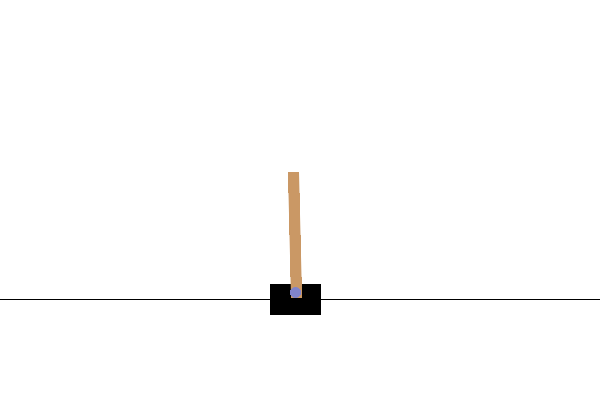

In [16]:
from IPython import display as ipythondisplay
from PIL import Image
from pathlib import Path

def render_episode_as_gif_frames(env_name, actor, max_steps):
    env = gym.make(env_name, render_mode='rgb_array')
    
    state, _ = env.reset()
    
    state = tf.constant(state, dtype=tf.float32)
    screen = env.render()
    images = [Image.fromarray(screen)]
    
    for i in range(1, max_steps+1):
        state = tf.expand_dims(state, 0)
        action_probs = actor(state)
        action = np.argmax(np.squeeze(action_probs))
        
        state, reward, done, _, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)
        
        screen = env.render()
        images.append(Image.fromarray(screen))
        
        if done:
            break

    return images

def save_frames_as_gif(frames: list[Image.Image], path: Path, **kwargs):
    frames[1].save(
        path,
        save_all=True,
        append_images=frames[2:],
        optimize=False,
        duration=40,
        loop=0,
        **kwargs,
    )
    
import IPython.display
def display_gif(path: Path) -> IPython.display.DisplayHandle:
    return display(
        IPython.display.Image(
            data=open(path,'rb').read(), format='png'),
        )
    
gif_path = './images/gym_CartPole.gif'
frames = render_episode_as_gif_frames('CartPole-v1', actor, max_steps_per_episode)
save_frames_as_gif(frames, gif_path)
display_gif(gif_path)

In [9]:
actions, action_probs, values, rewards = run_episode(
    env=env,
    max_steps=100,
    actor=actor,
    critic=critic,
    action_selection_fn=lambda probs: np.random.choice(n_actions, p=probs[0].numpy())
)
len(actions)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Caskroom/miniforge/base/envs/eqmarl/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):  File "/usr/local/Caskroom/miniforge/base/envs/eqmarl/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)  File "/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_9292/4143689581.py", line 1, in <module>
    actions, action_probs, values, rewards = run_episode(  File "/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_9292/1531571545.py", line 36, in run_episode
    actions.write(t, tf.squeeze(action))  File "/usr/local/Caskroom/miniforge/base/envs/eqmar

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Caskroom/miniforge/base/envs/eqmarl/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):  File "/usr/local/Caskroom/miniforge/base/envs/eqmarl/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)  File "/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_9292/4143689581.py", line 1, in <module>
    actions, action_probs, values, rewards = run_episode(  File "/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_9292/1531571545.py", line 36, in run_episode
    actions.write(t, tf.squeeze(action))  File "/usr/local/Caskroom/miniforge/base/envs/eqmar

DONE: t=<tf.Tensor: shape=(), dtype=int32, numpy=16>


17

In [ ]:
# actions, action_probs, rewards, values = zip(*[
#     (interaction['action'], interaction['action_prob'], interaction['reward'], interaction['value'])
#     for interaction in history
# ])
# actions = tf.squeeze(tf.convert_to_tensor(actions))
# action_probs = tf.squeeze(tf.convert_to_tensor(action_probs))
# rewards = tf.squeeze(tf.convert_to_tensor(rewards))
# values = tf.squeeze(tf.convert_to_tensor(values))

In [32]:
returns = get_expected_returns(rewards, gamma=0.9)
actor_loss = compute_actor_loss(action_probs, values, returns)
critic_loss = keras.losses.Huber(reduction=keras.losses.Reduction.SUM)(values, returns)

actor_loss, critic_loss

(<tf.Tensor: shape=(), dtype=float32, numpy=-1.4052567>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.40151966>)

In [13]:
pd.DataFrame(history)

,state,action,action_prob,value,reward,done,next_state
0,"((tf.Tensor(0.049874656, shape=(), dtype=float...",1,"tf.Tensor(0.3407701, shape=(), dtype=float32)","((tf.Tensor(0.009617644, shape=(), dtype=float...",1.0,False,"[0.049916547, 0.1977424, -0.03891375, -0.34171..."
1,"((tf.Tensor(0.049874656, shape=(), dtype=float...",0,"tf.Tensor(0.6592299, shape=(), dtype=float32)","((tf.Tensor(0.009617644, shape=(), dtype=float...",1.0,False,"[0.053871393, 0.0031950858, -0.045748062, -0.0..."
2,"((tf.Tensor(0.049874656, shape=(), dtype=float...",0,"tf.Tensor(0.6592299, shape=(), dtype=float32)","((tf.Tensor(0.009617644, shape=(), dtype=float...",1.0,False,"[0.053935297, -0.1912421, -0.04697913, 0.21635..."
3,"((tf.Tensor(0.049874656, shape=(), dtype=float...",0,"tf.Tensor(0.6592299, shape=(), dtype=float32)","((tf.Tensor(0.009617644, shape=(), dtype=float...",1.0,False,"[0.050110452, -0.38566205, -0.04265209, 0.4938..."
4,"((tf.Tensor(0.049874656, shape=(), dtype=float...",0,"tf.Tensor(0.6592299, shape=(), dtype=float32)","((tf.Tensor(0.009617644, shape=(), dtype=float...",1.0,False,"[0.042397212, -0.58015734, -0.03277502, 0.7727..."
5,"((tf.Tensor(0.049874656, shape=(), dtype=float...",0,"tf.Tensor(0.6592299, shape=(), dtype=float32)","((tf.Tensor(0.009617644, shape=(), dtype=float...",1.0,False,"[0.030794065, -0.77481335, -0.017319117, 1.054..."
6,"((tf.Tensor(0.049874656, shape=(), dtype=float...",0,"tf.Tensor(0.6592299, shape=(), dtype=float32)","((tf.Tensor(0.009617644, shape=(), dtype=float...",1.0,False,"[0.0152977975, -0.9697015, 0.0037806472, 1.342..."
7,"((tf.Tensor(0.049874656, shape=(), dtype=float...",1,"tf.Tensor(0.3407701, shape=(), dtype=float32)","((tf.Tensor(0.009617644, shape=(), dtype=float...",1.0,False,"[-0.004096233, -0.7746273, 0.030624349, 1.0506..."
8,"((tf.Tensor(0.049874656, shape=(), dtype=float...",0,"tf.Tensor(0.6592299, shape=(), dtype=float32)","((tf.Tensor(0.009617644, shape=(), dtype=float...",1.0,False,"[-0.01958878, -0.9701418, 0.051638097, 1.3528237]"
9,"((tf.Tensor(0.049874656, shape=(), dtype=float...",1,"tf.Tensor(0.3407701, shape=(), dtype=float32)","((tf.Tensor(0.009617644, shape=(), dtype=float...",1.0,False,"[-0.038991615, -0.77570486, 0.07869457, 1.0767..."


In [69]:
from PIL import Image
from pathlib import Path

def save_frames_as_gif(frames: list[Image.Image], path: Path, **kwargs):
    frames[1].save(
        path,
        save_all=True,
        append_images=frames[2:],
        optimize=False,
        duration=40,
        loop=0,
        **kwargs,
    )


def render_interactions_as_frames(
    env_name: str,
    interactions: list[dict[str, Any]],
    ) -> list[Image.Image]:
    env = gym.make(env_name, render_mode='rgb_array')
    state = env.reset()
    frames = []
    for interaction in interactions:
        im = Image.fromarray(env.render())
        frames.append(im)
        state, _, done, _, _ = env.step(interaction['action'])
        if done: 
            break
    env.close()
    return frames

In [61]:
import IPython.display
def display_gif(path: Path) -> IPython.display.DisplayHandle:
    return display(
        IPython.display.Image(
            data=open(path,'rb').read(), format='png'),
        )

In [70]:
gif_path = './images/gym_CartPole.gif'
frames = render_interactions_as_frames(env_name, history)
save_frames_as_gif(frames, path=gif_path)

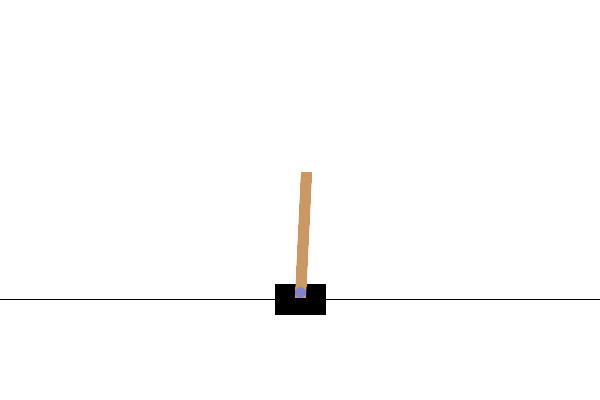

In [71]:
display_gif(gif_path)

In [54]:
actor.layers[1].circuit

0: ───Rx(theta0)───Ry(theta1)────Rz(theta2)────@───Rx(x0_0)───Rx(theta12)───Ry(theta13)───Rz(theta14)───────────────────────────────
                                               │
1: ───Rx(theta3)───Ry(theta4)────Rz(theta5)────X───@──────────Rx(x0_1)──────Rx(theta15)───Ry(theta16)───Rz(theta17)─────────────────
                                                   │
2: ───Rx(theta6)───Ry(theta7)────Rz(theta8)────────X──────────@─────────────Rx(x0_2)──────Rx(theta18)───Ry(theta19)───Rz(theta20)───
                                                              │
3: ───Rx(theta9)───Ry(theta10)───Rz(theta11)──────────────────X─────────────Rx(x0_3)──────Rx(theta21)───Ry(theta22)───Rz(theta23)───

In [55]:
tmp = tfq.convert_to_tensor([cirq.Circuit(), cirq.Circuit()])
tf.repeat(tmp, repeats=1)

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'\n\x0e\n\x0ctfq_gate_set\x12\x02\x08\x01',
       b'\n\x0e\n\x0ctfq_gate_set\x12\x02\x08\x01'], dtype=object)>

In [65]:
state, _ = env.reset()

# Convert state to batched tensor (batch size = 1).
state = tf.expand_dims(state, 0)

# Get action probabilities.
actor.layers[1].theta.shape, actor.layers[1].lmbd.shape
probs = actor([state])
# probs
# state
# actor.layers[1].circuit
# actor.layers[1].pqc.input_spec
probs

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.4158523, 0.5841477]], dtype=float32)>

---

In [40]:
sim = cirq.Simulator()

qubits = cirq.LineQubit.range(2)
obs = reduce(lambda a, b: a * b, [cirq.Z(q) for q in qubits]) # Z0 * Z1 * ...
# obs = obs + [cirq.Z(q) for q in qubits] # Z0, Z1, ...
print(type(qubits[0]))
circuit = cirq.Circuit(
    [cirq.H(q) for q in qubits],
    # obs,
    cirq.measure_single_paulistring(obs, key='m'),
    # cirq.measure(*qubits, key='m'),
)
print(f"dirac notation: {sim.simulate(circuit).dirac_notation()}")
print(f"measurements: {sim.run(circuit, repetitions=100).histogram(key='m')}")
# print(f"measurements: {sim.run(circuit, repetitions=100).histogram(key='m0')}")
# print(f"measurements: {sim.run(circuit, repetitions=100).histogram(key='m1')}")
# print(f"measurements: {sim.run(circuit, repetitions=100).histogram(key='m2')}")
print(circuit)

<class 'cirq.devices.line_qubit.LineQubit'>
dirac notation: 0.71|01⟩ + 0.71|10⟩
measurements: Counter({0: 51, 1: 49})
0: ───H───M(Z)('m')───
          │
1: ───H───M(Z)────────


In [77]:
qubits = cirq.LineQubit.range(2)
obs = reduce(lambda a, b: a * b, [cirq.Z(q) for q in qubits]) # Z0 * Z1 * ...
# obs = [cirq.Z(q) for q in qubits] # Z0, Z1, ...
circuit = cirq.Circuit(
    # [cirq.H(q) for q in qubits],
    [cirq.rx(sympy.Symbol(f'theta{i}'))(q) for i, q in enumerate(qubits)]
)
# tfq.convert_to_tensor([circuit])
# circuit

# # l = tfq.layers.AddCircuit(circuit)
# l = tfq.layers.PQC(circuit, obs)
l = tfq.layers.Sample()
quantum_data = tfq.convert_to_tensor([
    cirq.Circuit(),
    # cirq.Circuit([cirq.X(q) for q in qubits]),
])
# print(quantum_data.shape)
# quantum_data = tf.zeros(shape=(2,))
# quantum_data = keras.layers.Input(shape=(1,))
# policy = WeightedAlternatingSoftmaxPolicy(beta=1., n_actions=2)
# policy = AlternatingObservables(n_actions=4)

# x = l(quantum_data)
x = l(circuit, symbol_names=)
print(x)
# x = policy(x)
# print(x)

tf.Tensor([[-0.789022]], shape=(1, 1), dtype=float32)


In [3]:
env_name = "CartPole-v1"
env = gym.make(env_name)
env.reset()

(array([-0.00238119, -0.02606253, -0.02181742,  0.03740089], dtype=float32),
 {})

In [4]:
env_name = "FrozenLake-v1"
env = gym.make(env_name)
env.reset()

(0, {'prob': 1})

In [5]:
tf.Variable(
        initial_value=tf.constant([[(-1.)**i for i in range(4)]]),
        dtype='float32',
        trainable=True,
        name='observables-weights',
    )

<tf.Variable 'observables-weights:0' shape=(1, 4) dtype=float32, numpy=array([[ 1., -1.,  1., -1.]], dtype=float32)>

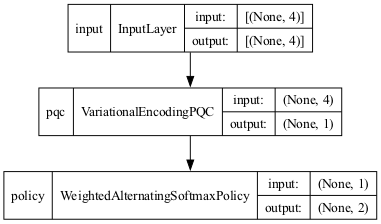

In [9]:
n_qubits = 4
n_layers = 5
n_actions = 2
beta = 1.0 # Inverse temperature parameter for softmax policy.
qubits = cirq.LineQubit.range(n_qubits)
ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x*y), ops)]

input_tensor = tf.keras.Input(shape=(n_qubits,), dtype='float32', name='input')
x = input_tensor
x = VariationalEncodingPQC(observables, qubits, n_layers, name='pqc')([x])
# observables
x = WeightedAlternatingSoftmaxPolicy(beta=beta, n_actions=n_actions, name='policy')(x)
model = tf.keras.Model(inputs=[input_tensor], outputs=x)
# pqc([input_tensor])
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [11]:
qubits = cirq.LineQubit.range(n_qubits)
input_tensor = tf.keras.Input(shape=(n_qubits,), dtype='float32', name='input')
x = input_tensor
outputs = VariationalEncodingPQC(observables, qubits, n_layers, name='pqc')([x])
outputs

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pqc')>

In [26]:
batch_dim = 12
inputs = np.zeros(shape=(batch_dim, 4))

In [29]:
# tf.gather(tf.shape(inputs[0]), 0)
batch_dim = tf.gather(tf.shape([inputs][0]), 0)
tiled_up_inputs = tf.tile([inputs][0], multiples=[1, n_layers])
tiled_up_inputs

<tf.Tensor: shape=(12, 20), dtype=float64, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     